In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import neurokit2 as nk
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
import mne
from sklearn.preprocessing import normalize
import torch

torch.cuda.set_device(2) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [200]:
# important variables
PRED_LENGTH = 1000 # how many samples in the future are we predicting
WINDOW_LENGTH = 4000 # how many samples we look to make predictions
TOTAL_LENGTH = PRED_LENGTH + WINDOW_LENGTH

SLIDE_SIZE = 100
INPUT_DIM = 5
OUTPUT_DIM = 5

In [201]:
# load data
file = "physionet.org/files/adfecgdb/1.0.0/r04.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# after normalization 
raw_data = normalize(raw_data,axis=1,norm="max")
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from /home/amirsalimi/ECG_Nexting/physionet.org/files/adfecgdb/1.0.0/r04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [202]:
# cleanup the data
for i in range(len(raw_data)):
    raw_data[i] = nk.ecg_clean(raw_data[i],method="neurokit")

<AxesSubplot:>

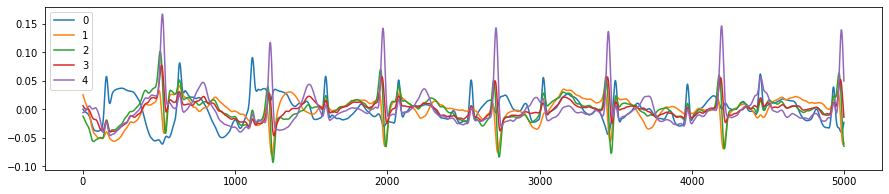

In [203]:
df = pd.DataFrame(raw_data.T).iloc[0:5000]
df.plot(kind="line",figsize=(15,3))

In [204]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, d,WINDOW_LENGTH,PRED_LENGTH,SLIDE_SIZE,):
        'Initialization'
        self.data = d
        self.step_size = SLIDE_SIZE
        self.window_length = WINDOW_LENGTH
        self.pred_length = PRED_LENGTH
        self.num_windows = (d.shape[-1]-self.window_length-self.pred_length)//self.step_size
        print(d.shape[-1],self.num_windows,self.window_length,self.pred_length)
    def __len__(self):
        'Denotes the total number of samples'
        return self.num_windows

    def __getitem__(self, index):
        'Generates one sample of data'
        n = index 
        X = self.data[:,n:n+self.window_length]
        y = self.data[:,n+self.window_length:n+self.window_length+self.pred_length]
        return X, y

In [205]:
sample_size = raw_data.shape[-1]
test_length = sample_size //5

training_set = Dataset(raw_data[:,0:test_length*4],WINDOW_LENGTH,PRED_LENGTH,SLIDE_SIZE)
training_generator = torch.utils.data.DataLoader(training_set,batch_size=1)

testing_set = Dataset(raw_data[:,test_length*4:],WINDOW_LENGTH,PRED_LENGTH,SLIDE_SIZE,)
testing_generator = torch.utils.data.DataLoader(testing_set,batch_size=1)

240000 2350 4000 1000
60000 550 4000 1000


In [206]:
past,future = testing_set[0][0],testing_set[0][1]

P-value:  0.006741541856324818


/home/amirsalimi/miniconda3/envs/nexting/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


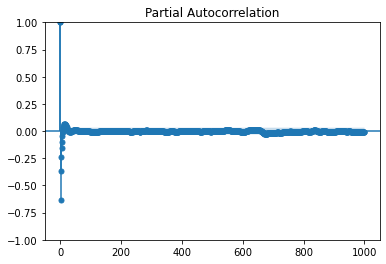

In [207]:
lead = lead
df_stationarityTest = adfuller(past[lead], autolag='AIC')
print("P-value: ", df_stationarityTest[1])
pacf = plot_pacf(past[lead], lags=1000)

In [ ]:
for lead in range(len(raw_data)):
    ar_model = AutoReg(past[lead], lags=1000).fit()
    pred = ar_model.predict(start=WINDOW_LENGTH, end=WINDOW_LENGTH+PRED_LENGTH, dynamic=False)
    plt.plot(future[lead], color='red')
    plt.plot(pred,color='blue')
    plt.show()

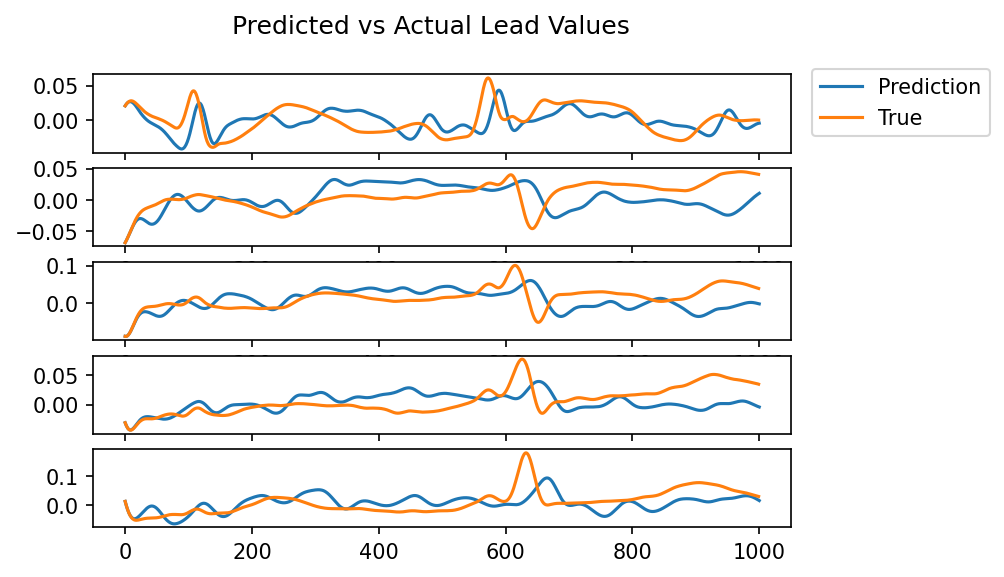

In [330]:
fig, axs = plt.subplots(len(raw_data))
for lead in range(len(raw_data)):
    fig.suptitle('Predicted vs Actual Lead Values')
    ar_model = AutoReg(past[lead], lags=1000).fit()
    pred = ar_model.predict(start=WINDOW_LENGTH, end=WINDOW_LENGTH+PRED_LENGTH, dynamic=False)
    axs[lead].plot(pred,label='Prediction')
    axs[lead].plot(future[lead],label='True')
#     ax2.plot(x, -y)

fig.set_dpi(150)
plt.legend(bbox_to_anchor=(1.3, 6))
# fig.ylabel('some numbers')
fig.show()

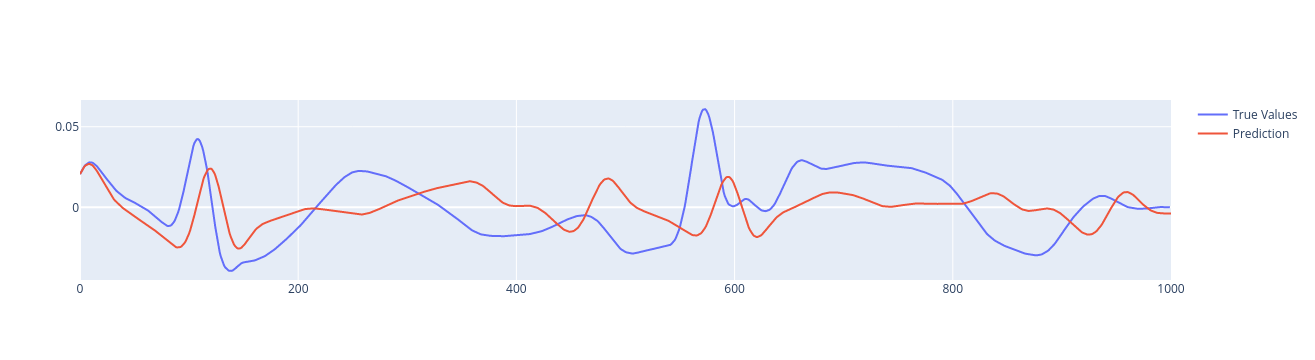

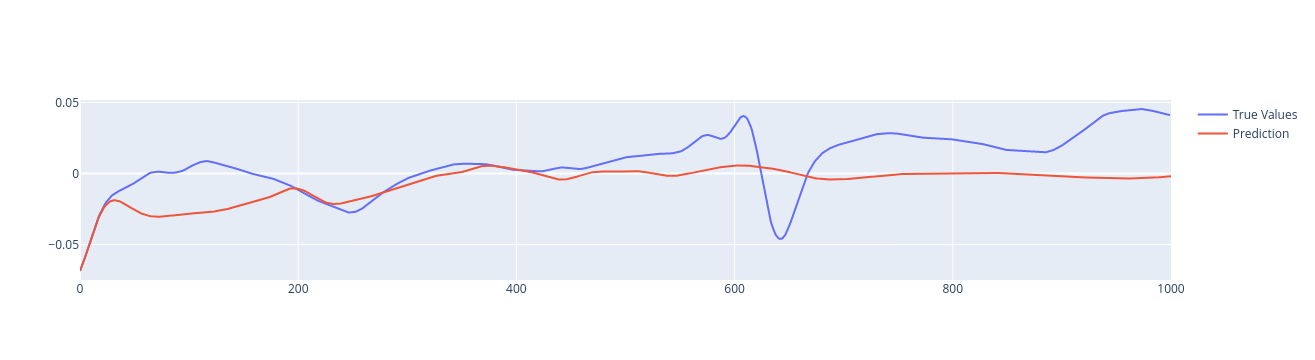

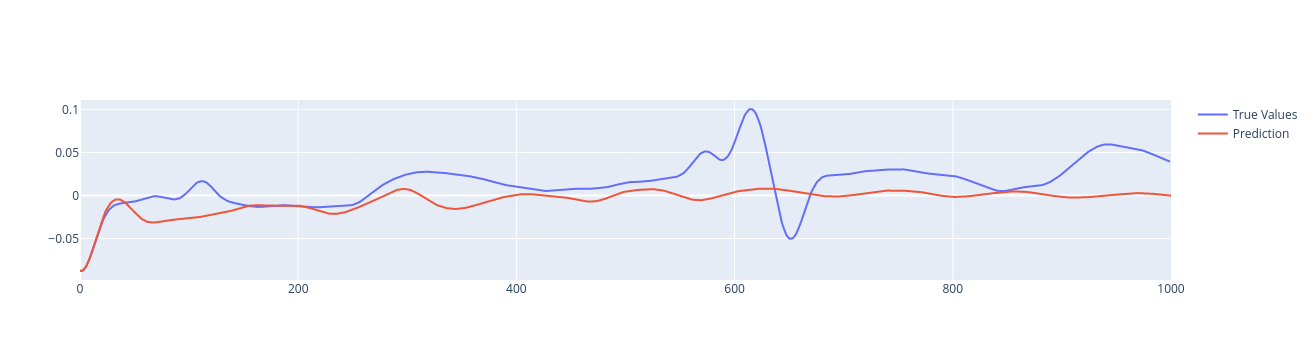

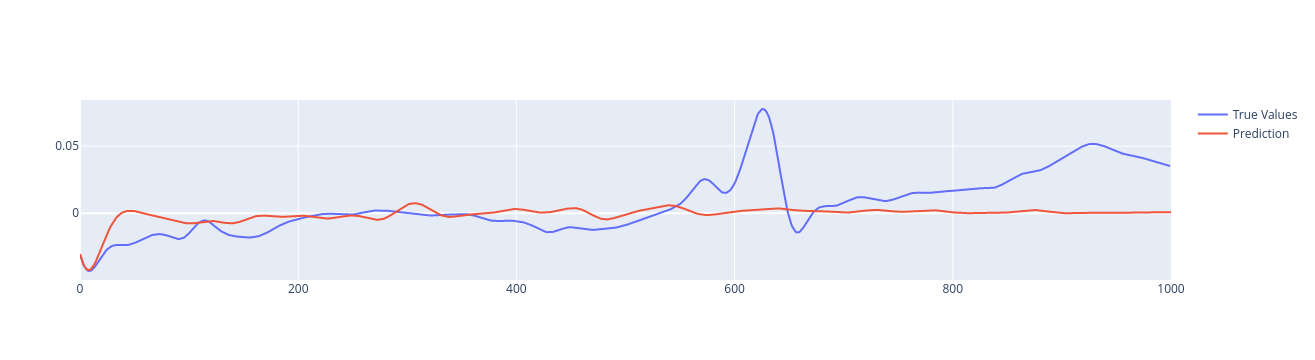

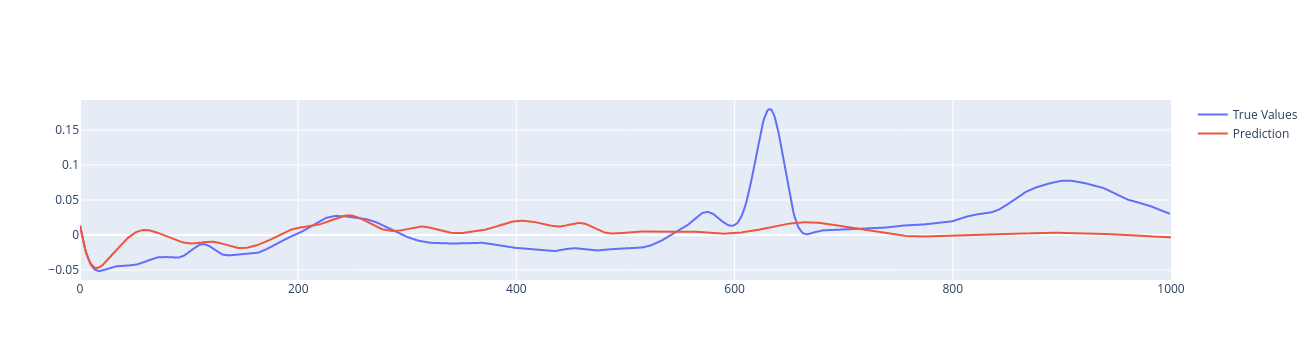

In [241]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
for lead in range(len(raw_data)):
    ar_model = AutoReg(past[lead], lags=500).fit()
    pred = ar_model.predict(start=WINDOW_LENGTH, end=WINDOW_LENGTH+PRED_LENGTH, dynamic=False)
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=future[lead],name='True Values',),)
    fig.add_trace(go.Scatter(y=pred,name='Prediction',))
    fig.show()